In [32]:
from datetime import datetime
from functools import partial
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import numpy as np
import joblib

from incentive import assemble_W, assemble_S, compute_incentive
from wandb_utils import get_wandb_history
from plotting import plot_metric, plot_multi_validator_metric, plot_incentive, plot_incentives
from utils import average_challenges_per_tempo
from simulator import Simulator

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│    8                                                                                             │
│    9 from incentive import assemble_W, assemble_S, compute_incentive                             │
│   10 from wandb_utils import get_wandb_history                                                   │
│ ❱ 11 from plotting import plot_metric, plot_multi_validator_metric, plot_incentive, plot_ince    │
│   12 from utils import average_challenges_per_tempo                                              │
│   13 from simulator import Simulator                                                             │
│   14                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: cannot import name 'plot_incentive' from 'plotting' (/home/user/scoring_simulator/plotting.py)

## Query W&B or Load Locally Cached Data

In [2]:
# `load_cached_history` = True will read local pickle file at fname
# `load_cached_history` = False will query W&B
load_cached_history = True 
write_to_history_cache = True
fname = 'vali_histories_2days.pkl'

#  Earlist time (epoch) from which to pull W&B runs
start_ts = 1727803270 #1727846400 # 1727886242 #

# Names of W&B runs to query
VALIDATOR_UIDS = [131, 193, 107]#, 19, 107] # [6, 17, 19, 20, 107, , 236, 250, 20, 122
#VALIDATORS = ['validator-193-1.1.0', 'validator-19-1.1.0', 'validator-107-1.1.0']
VALIDATORS = [f'validator-{uid}-1.1.0' for uid in VALIDATOR_UIDS]

# Keys will be validator names, values will be history dataframes
HISTORY_DFS = {}


In [3]:
if load_cached_history:
    HISTORY_DFS = joblib.load(fname)
else:
    for vali in VALIDATORS:
        print(f"Loading data from {vali}")
        HISTORY_DFS[vali] = get_wandb_history(
            project='bitmind-subnet',
            entity='bitmindai',
            validator_name=vali,
            start_ts=start_ts,
            end_ts=None, 
            verbosity=0)

    if write_to_history_cache:
        joblib.dump(HISTORY_DFS, fname)

for vali, history_df in HISTORY_DFS.items():
    print(vali)
    avg, counts = average_challenges_per_tempo(history_df)
    format_time = lambda v: datetime.fromtimestamp(v).strftime('%Y-%m-%dT%H:%M:%S')
    print(f'\tDate Range: {format_time(history_df._timestamp.min())} : {format_time(history_df._timestamp.max())}')
    print(f'\tDataFrame shape: {history_df.shape}')
    print(f'\tAverage Challenges Per Tempo: {avg}')
    print(f'\t\tChallenges Per Tempo: {counts}')
    

validator-131-1.1.0
	Date Range: 2024-10-01T15:28:19 : 2024-10-03T17:22:32
	DataFrame shape: (2106, 4)
	Average Challenges Per Tempo: 50.142857142857146
		Challenges Per Tempo: [56, 59, 56, 59, 54, 55, 58, 58, 59, 59, 56, 60, 58, 58, 59, 58, 58, 58, 57, 57, 54, 54, 57, 59, 56, 58, 58, 59, 58, 57, 3, 0, 0, 0, 0, 55, 60, 57, 59, 59, 57, 34]
validator-193-1.1.0
	Date Range: 2024-10-01T14:36:14 : 2024-10-03T17:24:31
	DataFrame shape: (2487, 4)
	Average Challenges Per Tempo: 57.83720930232558
		Challenges Per Tempo: [60, 57, 58, 60, 56, 59, 57, 58, 58, 58, 60, 60, 60, 59, 60, 58, 60, 58, 59, 58, 57, 54, 55, 58, 59, 58, 61, 59, 60, 61, 58, 60, 59, 60, 60, 57, 60, 59, 60, 60, 59, 60, 20]
validator-107-1.1.0
	Date Range: 2024-10-01T13:33:38 : 2024-10-03T17:24:54
	DataFrame shape: (2288, 4)
	Average Challenges Per Tempo: 52.0
		Challenges Per Tempo: [51, 52, 53, 53, 50, 54, 57, 53, 53, 54, 54, 55, 52, 54, 53, 52, 54, 55, 54, 50, 50, 54, 47, 50, 57, 52, 53, 52, 53, 53, 54, 51, 55, 53, 55, 52, 51

In [4]:
HISTORY_DFS = {vali: HISTORY_DFS[vali] for vali in VALIDATORS}

## Run Simulation or Load Simulation Results

In [5]:
# `load_cached_scores` = False will run simulations for each validator with the specified reward functions in parallel
# `load_cached_scores` = True will read local pickle file
load_cached_scores = False  

# `write_to_cache` = True will overwrite scored_fname
write_to_cache = True
scored_fname = 'histories_scored_ht.pkl'

# Number of dataframe rows over which to compute rewards and scores, set to `None` for all rows
score_num_challenges = None

# Keys are validator (w&b run) names, values are dataframes with reward & score columns
SCORED_DFS = {}

In [6]:
if load_cached_scores:
    SCORED_DFS = joblib.load(scored_fname)
else:  
    simulation_fn = partial(run_simulation, limit=score_num_challenges)

    # progress bar is kinda jank with multiprocessing, could fix but nah
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(
            simulation_fn,
            [HISTORY_DFS[vali] for vali in VALIDATORS])
    
    SCORED_DFS = {vali: scored_df[scored_df.rewards_new.notna()] for vali, scored_df in zip(VALIDATORS, results)}
    if write_to_cache:
        joblib.dump(SCORED_DFS, scored_fname)

Computing Rewards, Scores and Weights: 100%|██████████| 2288/2288 [42:49<00:00,  1.12s/it]


In [7]:
from weights import U16_MAX

for vali, scored_df in SCORED_DFS.items():
    SCORED_DFS[vali]['weights_normed_old'] = scored_df['weights_old'].apply(lambda l: [v/U16_MAX for v in l])
    SCORED_DFS[vali]['weights_normed_new'] = scored_df['weights_new'].apply(lambda l: [v/U16_MAX for v in l])

WEIGHT_SET_DFS = {vali: df.iloc[::50] for vali, df in SCORED_DFS.items()}

## Plot Rewards, Scores, Weights, Incentive

**"New" refers to weights/scores/rewards from the new reward functions, "old" is the original binary reward function**

### Incentive

In [8]:
S = assemble_S(VALIDATOR_UIDS)

W_old = assemble_W(SCORED_DFS, 'weights_old')
I_old = compute_incentive(W_old, S)

W_new = assemble_W(SCORED_DFS, 'weights_new')
I_new = compute_incentive(W_new, S)

I_old = np.sort(I_old[I_old.nonzero()])
I_new = np.sort(I_new[I_new.nonzero()])


In [9]:
W_new[0][:10]

array([29180., 24535., 22799., 42106., 12226., 23519.,     0., 29828.,
       41419., 26210.])

In [10]:
W_old[0][:10]

array([31759., 22555., 17285., 32080., 12856., 25423.,     0., 28345.,
       42438., 24506.])

In [ ]:
plot_incentives({'new': I_new, 'old': I_old})

### Inspect Same Miner over Multiple Validators

In [ ]:
uids = [226, 179, 172]#, 39]
start_idx = -100
end_idx = -1

#### Weights
note that weights aren't actually set this often

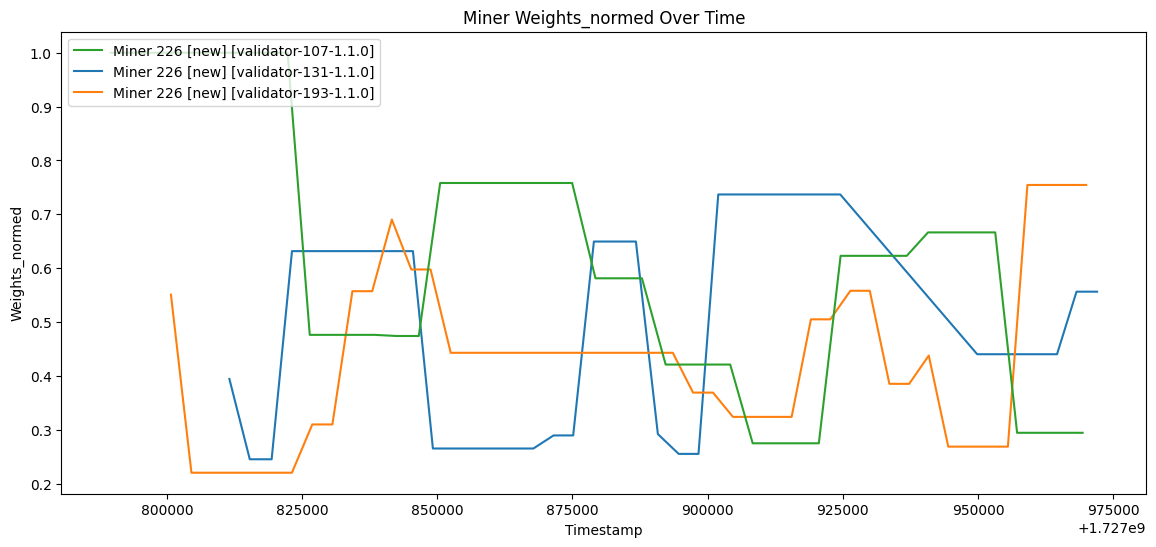

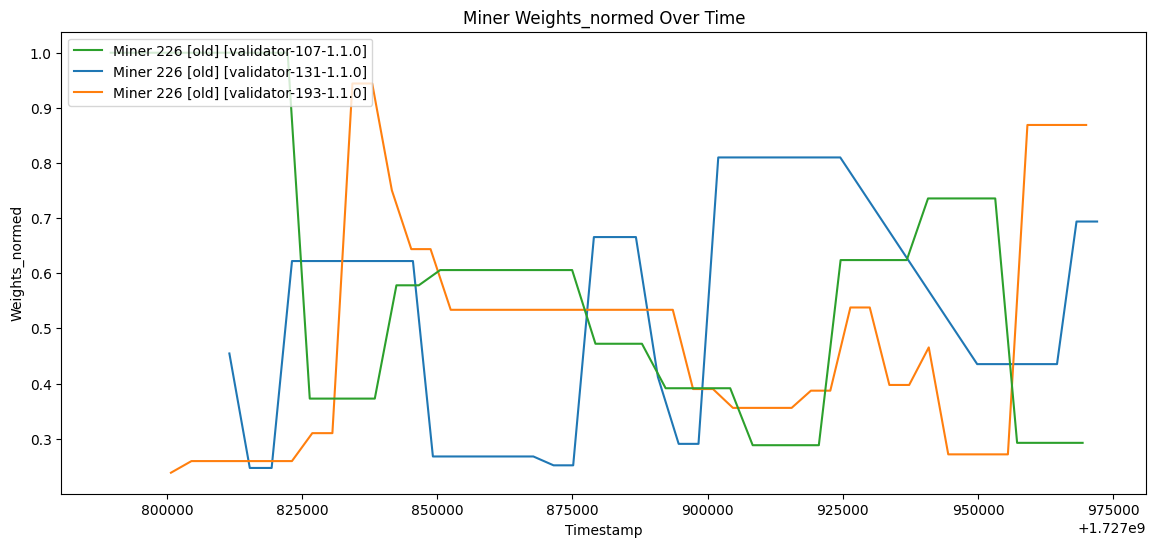

In [30]:
plot_multi_validator_metric(
    WEIGHT_SET_DFS, 
    idx_range=[0, -1], 
    metric='weights_normed', 
    suffixes=['new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='upper left')

plot_multi_validator_metric(
    WEIGHT_SET_DFS, 
    idx_range=[0, -1], 
    metric='weights_normed', 
    suffixes=['old'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='upper left')

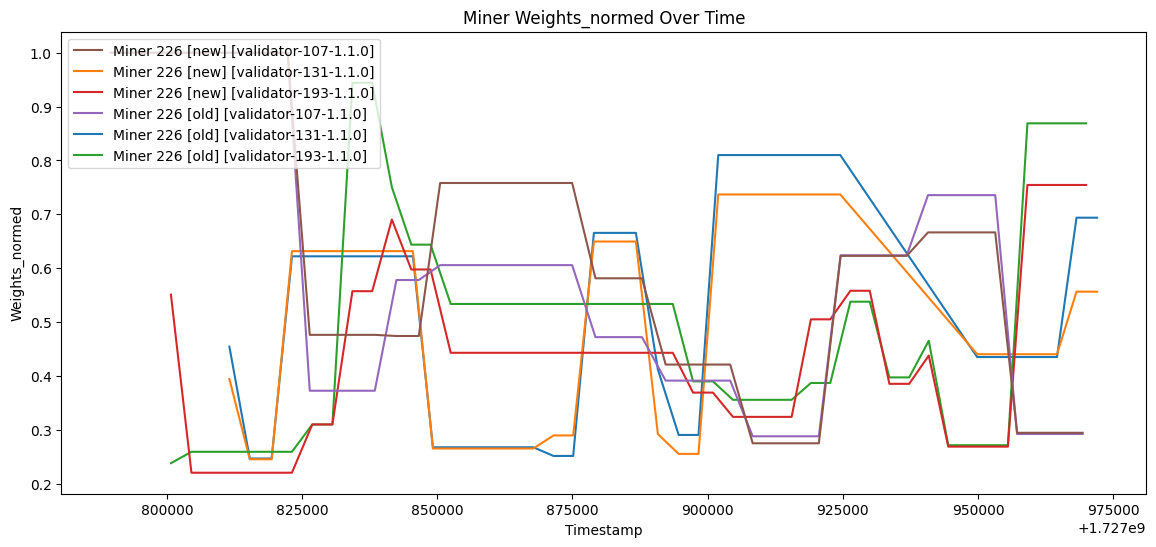

In [31]:
plot_multi_validator_metric(
    WEIGHT_SET_DFS, 
    idx_range=[start_idx, end_idx], 
    metric='weights_normed', 
    suffixes=['old', 'new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='upper left')


#### Scores

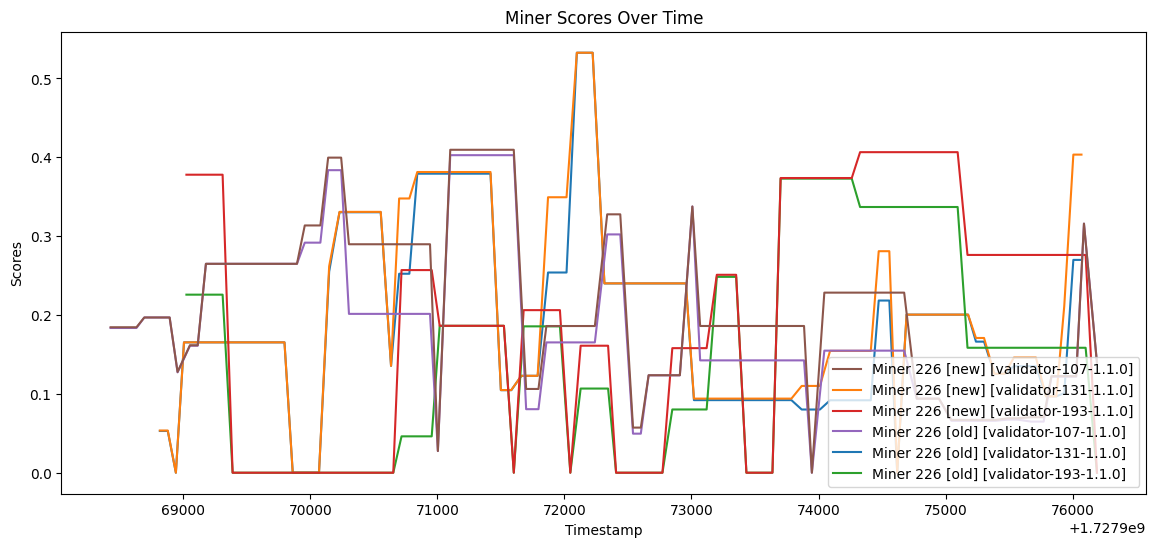

In [17]:
plot_multi_validator_metric(
    SCORED_DFS, 
    idx_range=[start_idx, end_idx], 
    metric='scores', 
    suffixes=['old', 'new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='lower right')

#### Rewards

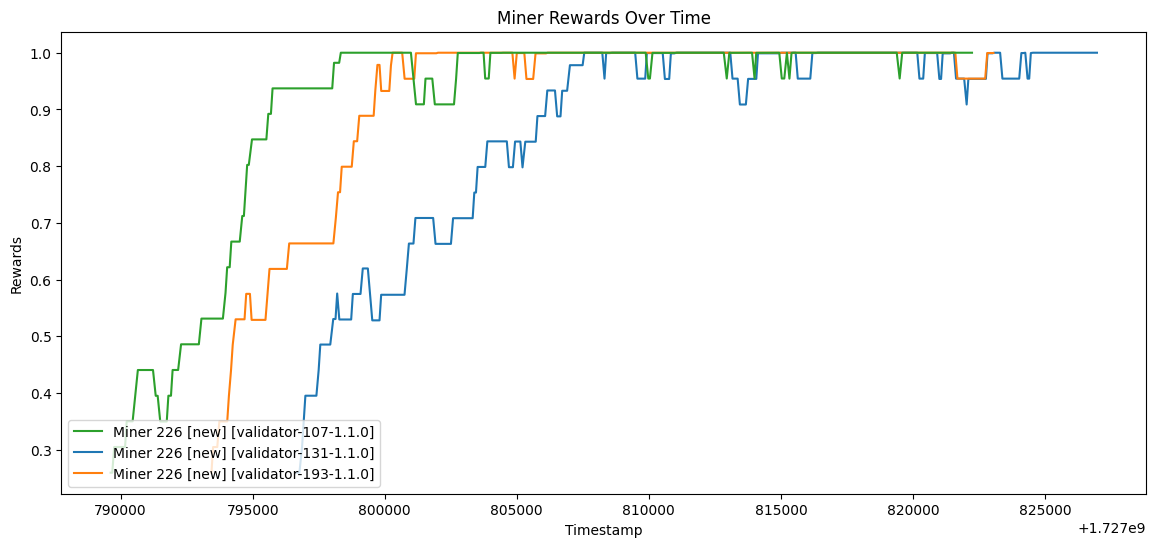

In [21]:
plot_multi_validator_metric(
    SCORED_DFS, 
    idx_range=[0, 400], 
    metric='rewards', 
    suffixes=['new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='lower left')

### Inspect Individual Validators

validator-131-1.1.0


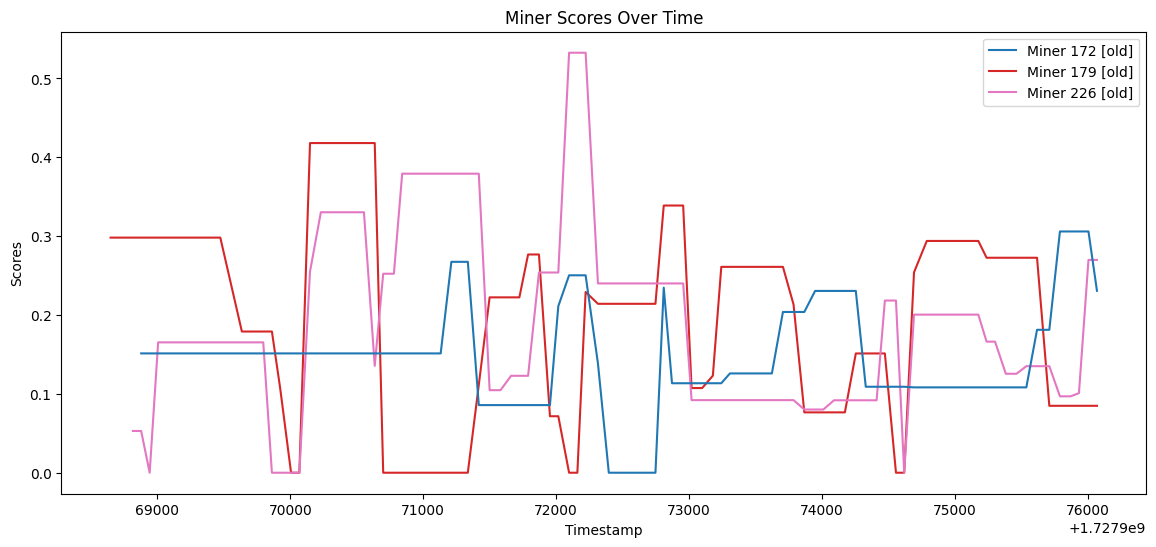

validator-193-1.1.0


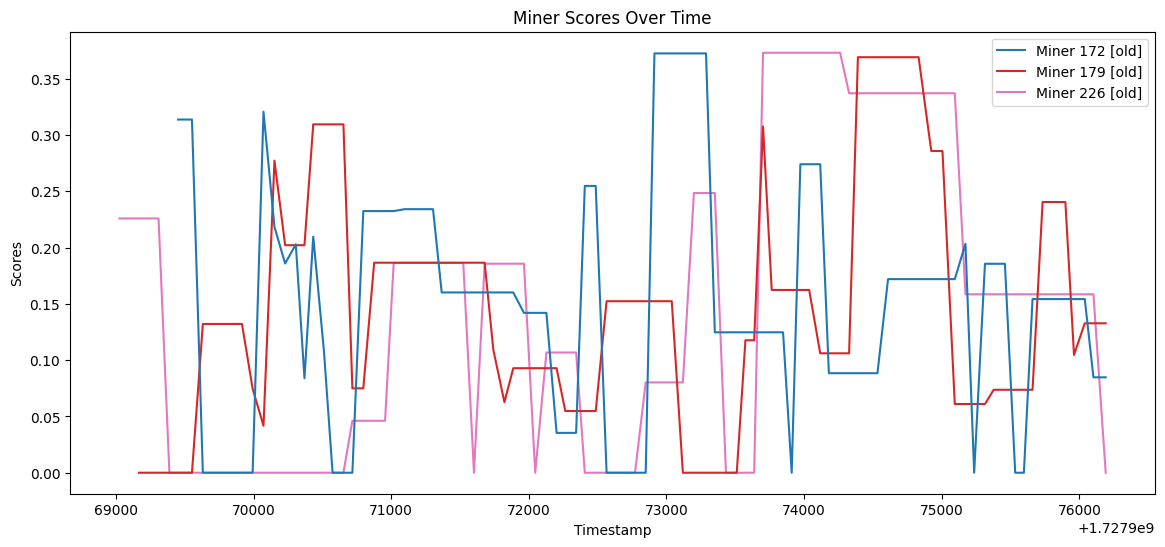

validator-107-1.1.0


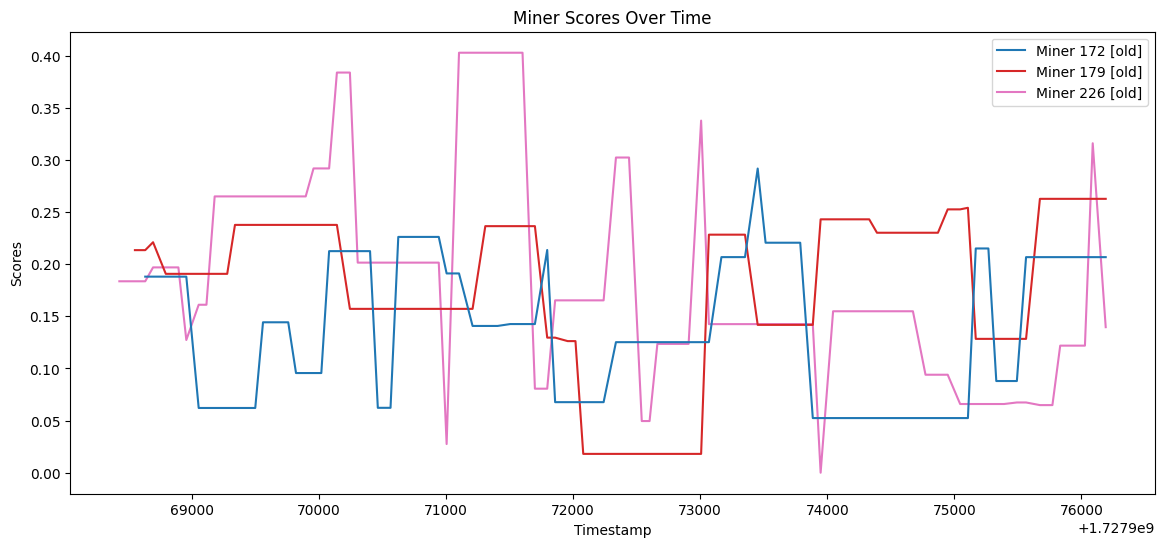

In [22]:
for vali, scored_df in SCORED_DFS.items():
    print(vali)
    plot_metric(scored_df[start_idx: end_idx], 'scores', uids=uids, suffixes=['old'], map_uids_to_colors=True)


validator-131-1.1.0


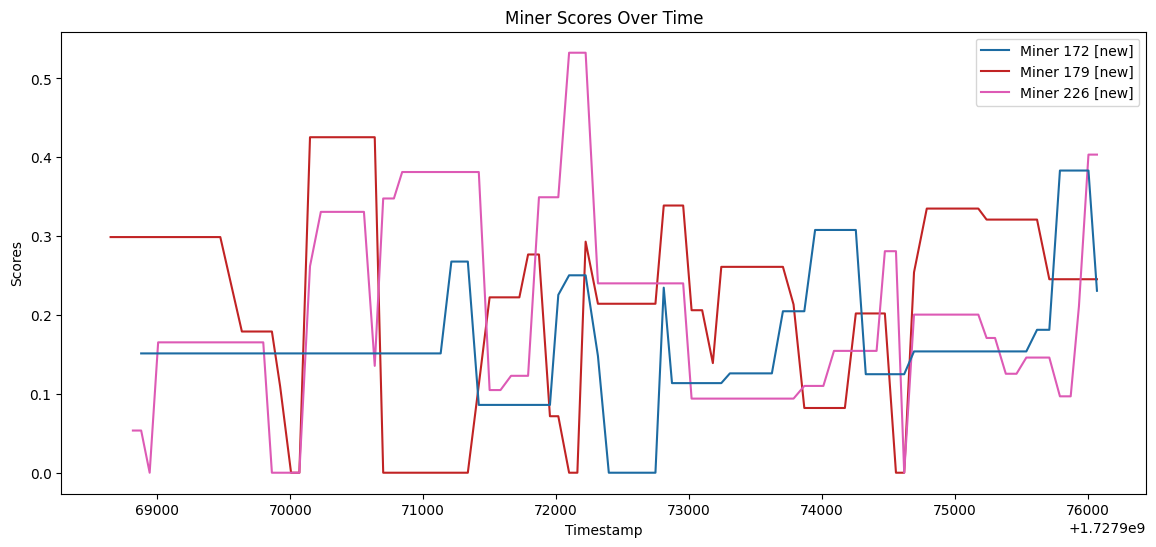

validator-193-1.1.0


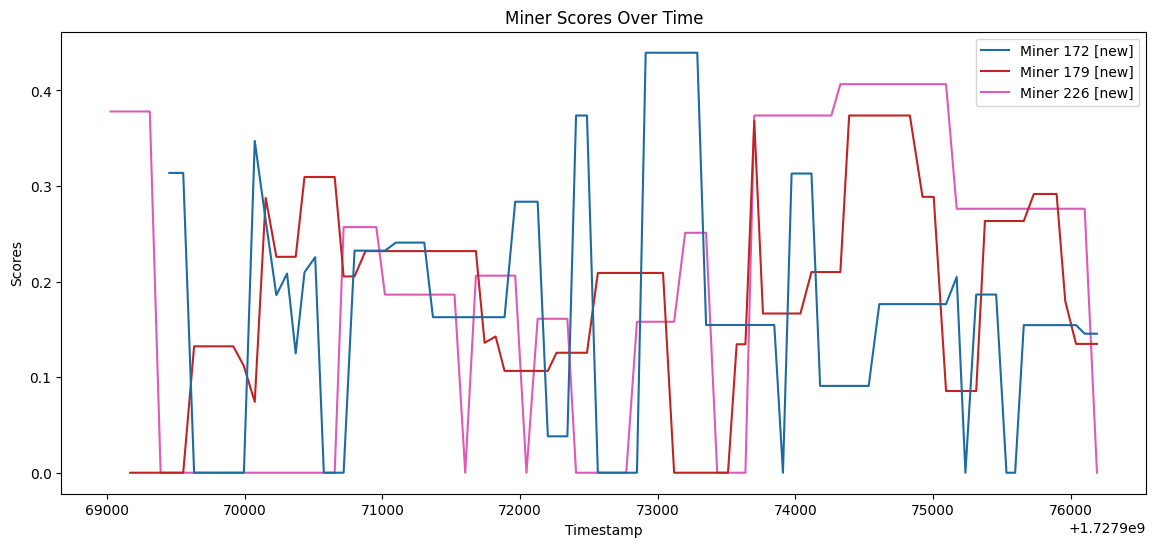

validator-107-1.1.0


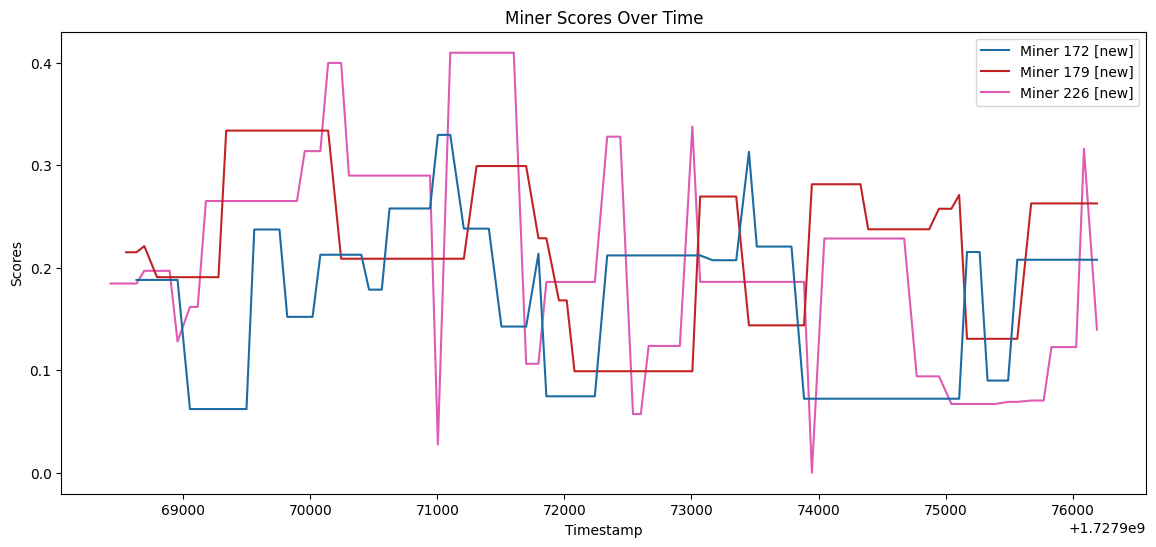

In [23]:

for vali, scored_df in SCORED_DFS.items():
    print(vali)
    plot_metric(scored_df[start_idx: end_idx], 'scores', uids=uids, suffixes=['new'], map_uids_to_colors=True)


validator-131-1.1.0


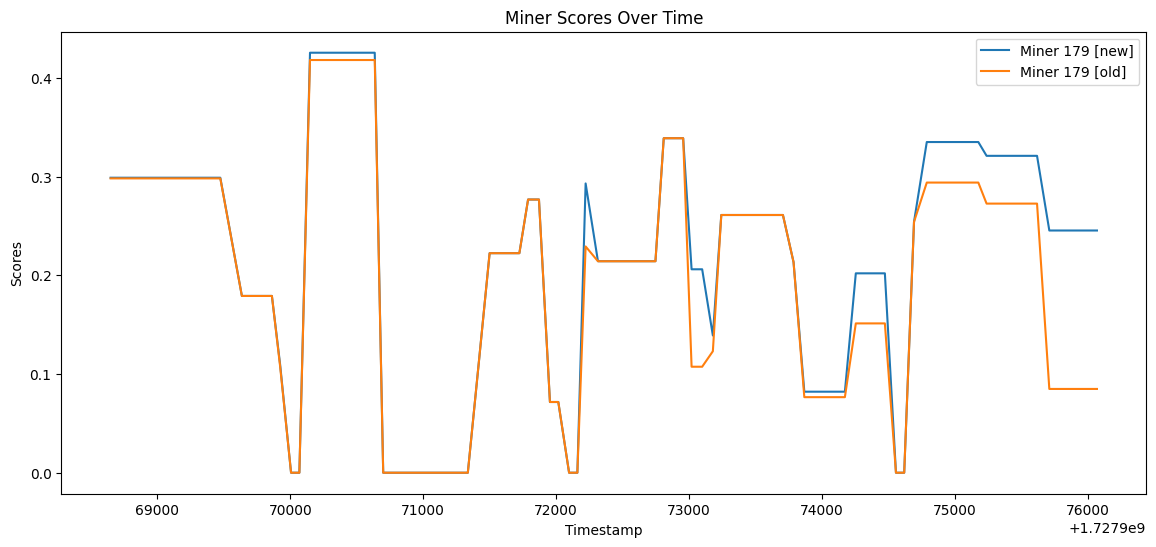

validator-193-1.1.0


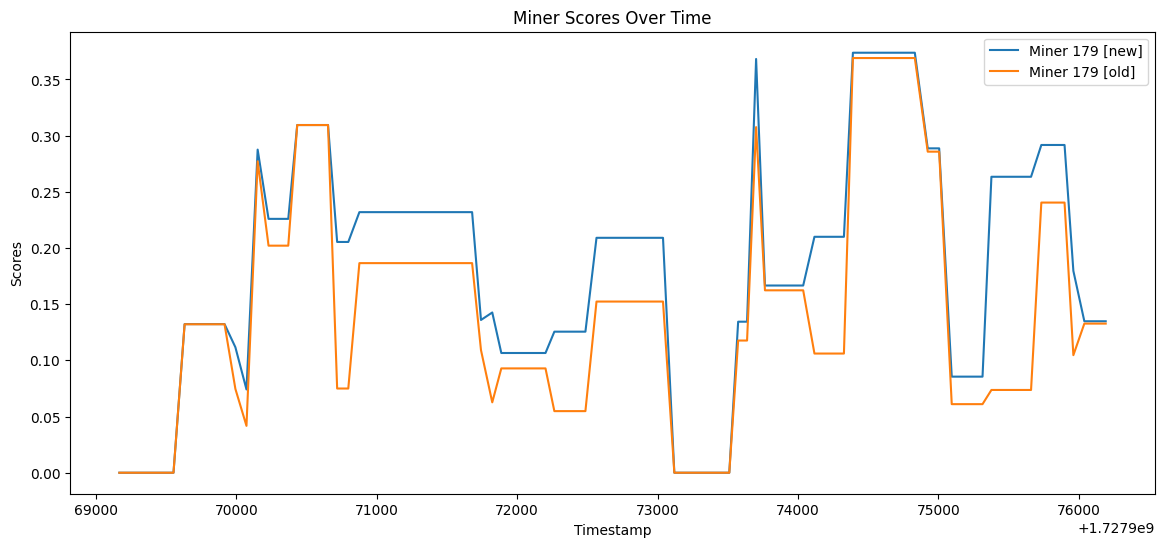

validator-107-1.1.0


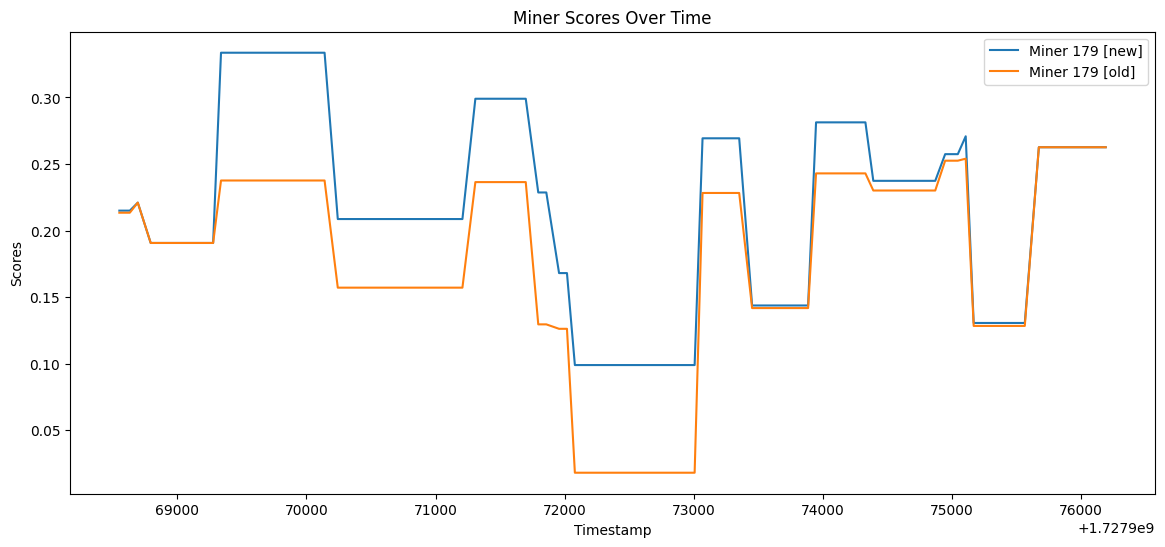

In [24]:

for vali, scored_df in SCORED_DFS.items():
    print(vali)
    plot_metric(scored_df[start_idx: end_idx], 'scores', uids=[uids[1]], suffixes=['new', 'old'], map_uids_to_colors=False)
